# Narrowband modulations
* Pulse position modulation
* Binary Phase Shift Keying
* Quadrature Phase Shift Keying

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Preliminaries
To run the simulations, one needs the following routines:
* To generate complex-valued noise sequences
* To convert signal-to-noise ratio into the Gaussiuan distribution parameters
* To generate Rayleigh fading coefficients

$$
\text{SNR} = \frac{a^2}{N_0} \Rightarrow N_0 = \frac{a^2}{\text{SNR}}
$$

In [3]:
# Generate complex-valued noise
def gen_noise(N, snr_db):
    # Do not forget np.sqrt(1/2) factor for CN circular noise! 
    sigma = np.sqrt(1 / (2 * 10 ** (snr_db / 10)))
    z_re = np.random.normal(0, 1, size=(N,))
    z_im = np.random.normal(0, 1, size=(N,))
    return (z_re + 1j * z_im) * sigma  # The total power is 2 * sigma^2

def gen_rayleigh_fading(N):
    # Generate unit power complex-valued noise series
    return gen_noise(N, 0)

## How to run simulations with Bernoulli trials

Consider an experiment that evaluates the error probability $\hat{p}$, and every single $i$-th test returns either $\hat{p}^{(i)} = 0$ - if the error did not happen, or $\hat{p}^{(i)}=1$ - if the error happened.

Given $n$ independent tests, one needs to evaluete the [confidence intervals](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) of the resulting error variable
$$
\hat{p} = \frac{1}{n}\sum_{i = 1}^n\hat{p}^{(i)}
$$

Under the central limit theorem, this confidence interval is
$$
\hat{p} \pm z\sqrt{\frac{\hat{p}(1 - \hat{p})}{n}} \approx z\sqrt{\frac{\hat{p}}{n}},
$$
where $z$ is a standard normal distribution quantile.

The relative error depends only on the number of errors $n_e$ happened in the series of single tests:
$$
\Delta\hat{p} = z\sqrt{\frac{\hat{p}(1 - \hat{p})}{n}} \Rightarrow \frac{\Delta \hat{p}}{\hat{p}} = \frac{z}{\sqrt{\hat{p}n}} = \frac{z}{\sqrt{n_e}}
$$

Thus, one must run single experiments until a required number of errors is not collected

In [4]:
def simulate(snr_db_range, max_errors, experiment_func):
    p_e = np.zeros(snr_db_range.shape)
    n_points = p_e.shape[0]
    # Run simulations:
    for i in range(n_points):
        snr_db = snr_db_range[i]
        n_errors = 0.0
        n_experiments = 0.0
        while n_errors < max_errors:
            n_errors += experiment_func(snr_db)
            n_experiments += 1
        p_e[i] = n_errors / n_experiments
    # Plot results:
    plt.plot(snr_db_range, p_e)
    plt.yscale('log')
    plt.xlabel('Signal-to-noise ratio [dB]')
    plt.ylabel('Error rate')
    plt.grid()
    # Hide plt.show() to add more data on a single figure
    # plt.show()

## Coherent vs non-coherent BER values

In [5]:
def get_ber_non_coherent(snr_db):
    snr_linear = 10 ** (snr_db / 10)
    return 0.5 / (1 + snr_linear)


def get_ber_coherent(snr_db):
    snr_linear = 10 ** (snr_range / 10)
    return 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))

# Pulse position modulation in the Rayleigh fading channel performance

In [6]:
# Pulse position modulation single symbol test in the i.i.d. Rayleigh fading model
def ppm_single_test(snr_db):
    # Transmitted signal: [0, 1] for '0' bit, and [1, 0] for '1' bit
    # The transmitted signal is a diagonal matrix
    # Note that we transmit once in two channel uses
    # To make the power per channel use equal to one, the transmitted amplitude must be scaled by np.sqrt(2)
    X = np.eye(2) * np.sqrt(2)
    # Generate two i.i.d. samples of fading channel
    h = gen_rayleigh_fading(2)
    # Select the transmitted symbol (the row of the matrix X)
    tx = np.random.randint(0, 2)
    # Received signal
    y = h * X[tx, :] + gen_noise(2, snr_db)
    # Compare the received energy
    y2 = np.abs(y) ** 2
    # Make a decision based on transmitted signal:
    tx_sign = (-1) ** tx
    return np.double(tx_sign * y2[1] > tx_sign * y2[0])

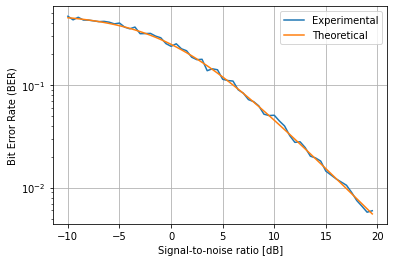

In [7]:
snr_range = np.arange(-10, 20, 0.5)
# Simulate pulse position modulation
simulate(
    snr_range,      # SNR values
    500,            # Maximum error count
    ppm_single_test # Single test function
)

plt.plot(snr_range, get_ber_non_coherent(snr_range))
plt.ylabel('Bit Error Rate (BER)')
plt.legend(['Experimental', 'Theoretical'])
plt.show()

# Frequency Shift Keying, non-coherent detection
Consider a binary modulation with the following orthogonal functions (at radio frequency $f_R$):
$$
x_0\left(t\right) = \exp\left(+2\pi j f_0 t\right)\times \exp\left(2\pi j f_R t\right)
$$
$$
x_1\left(t\right) = \exp\left(-2\pi j f_0 t\right)\times \exp\left(2\pi j f_R t\right)
$$
One can define a scalar product of functions as
$$
\int_{-\infty}^{+\infty}f\left(t\right)g^{*}\left(t\right)dt,
$$
where symbol $^*$ means the conjugate. The baseband signals $\exp\left(\pm2\pi j f_0 t\right)$ are orthogonal. One can satisfy chis condition this by choosing
$$
t = \frac{k}{2f_0}, \quad k \in \mathbb{N}.
$$

This actually a pulse position modulation in the frequency domain

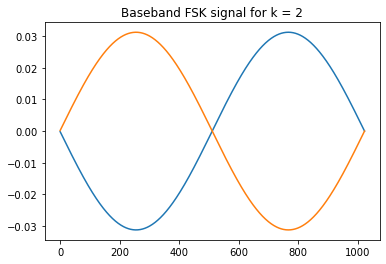

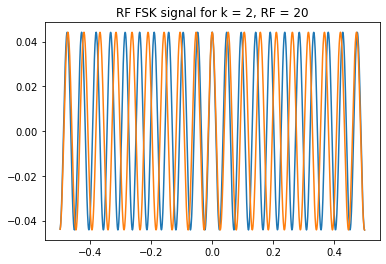

The signal energy (RF): 2.0, the dot product value: 7.850462293418876e-17
The signal energy (BB): 1.0, the dot product value: 6.938893903907228e-17


In [8]:
def get_fsk_waveform():
    k = 2
    # Define the time precision:
    N = 1024
    dt = 1 / N
    # Define the time range over the symbol:
    t = np.arange(-0.5 + dt, 0.5 + dt, dt)
    assert(len(t) == N)
    f0 = 0.5 * k  # Units of 1 / dt
    f_tx = 20     # Units of 1 / dt
    # Baseband signal
    x_0_bb = np.exp(+2 * np.pi * 1j * t * f0) / np.sqrt(N)
    x_1_bb = np.exp(-2 * np.pi * 1j * t * f0) / np.sqrt(N)
    # RF signal: the same idea as previously, but in the frequency domain, reaults in np.sqrt(2) scaler
    x_0 = x_0_bb * np.exp(+2 * np.pi * 1j * t * f_tx) * np.sqrt(2)
    x_1 = x_1_bb * np.exp(+2 * np.pi * 1j * t * f_tx) * np.sqrt(2)
    
    waveform = {
        'N':          N, # The number of samples at RF
        'x0':       x_0, # RF signal (of shape (N,))
        'x1':       x_1, # RF signal (of shape (N,))
        'x0_bb': x_0_bb, # BB signal (of shape (N,))
        'x1_bb': x_1_bb, # BB signal (of shape (N,))
        'f_tx':    f_tx, # RF frequency value
        't':          t, # time, N equidistant values in [-0.5, 0.5]

    }

    # Plot baseband signal:
    plt.plot(np.imag(x_0_bb))
    plt.plot(np.imag(x_1_bb))
    plt.title('Baseband FSK signal for k = {0}'.format(k))
    plt.show()
    
    # Plot RF signal:
    plt.figure()
    plt.plot(t, np.real(x_0))
    plt.plot(t, np.real(x_1))
    plt.title('RF FSK signal for k = {0}, RF = {1}'.format(k, f_tx))
    plt.show()
    
    # Check that the waveform consists of two orthogonal functions
    cross_dot = np.abs(np.sum(x_0 * np.conj(x_1)))
    signal_energy = np.abs(np.sum(x_0 * np.conj(x_0)))
    print('The signal energy (RF): {0}, the dot product value: {1}'.format(signal_energy, cross_dot))
    cross_dot = np.abs(np.sum(x_0_bb * np.conj(x_1_bb)))
    signal_energy = np.abs(np.sum(x_0_bb * np.conj(x_0_bb)))
    print('The signal energy (BB): {0}, the dot product value: {1}'.format(signal_energy, cross_dot))
    
    return waveform
# Get the RF waveforms:
waveform = get_fsk_waveform()

In [9]:
def fsk_single_run(snr_db, waveform, frequency_drift = 0):
    N = waveform['N']
    t = waveform['t']
    f_tx = waveform['f_tx']
    
    # Generate single fading channel sample
    h = gen_rayleigh_fading(1)

    # Simulate the frequency drift
    df = np.random.normal(0, 1) * frequency_drift
    # Received noisy baseband signal
    # By symmetry, we transmit only 0-th waveform
    y_bb = h * waveform['x0'] * np.exp(-2 * np.pi * 1j * t * (f_tx + df)) + gen_noise(N, snr_db)
    # Demodulation
    # Calculate the correlation for the received signal with both reference signals
    # Note that no channel information required for demodulation
    x_0_energy = np.abs(np.sum(y_bb * np.conj(waveform['x0_bb']))) ** 2
    x_1_energy = np.abs(np.sum(y_bb * np.conj(waveform['x1_bb']))) ** 2
    # Evaluate the error
    return np.double(x_1_energy > x_0_energy)

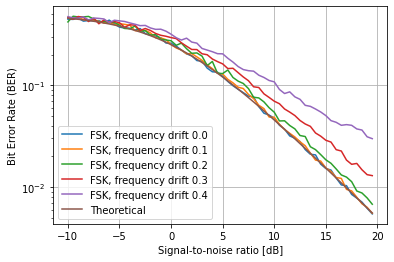

In [16]:
# Simulate pulse position modulation in the frequency domain
legend = []
# Run series of experiments corresponding to different frequency drifts
for i in range(5):
    freq_drift = 0.1 * i
    simulate(
        snr_range, # SNR values
        500,       # Maximum error count
        # Single test function, zero frequency drift
        lambda x: fsk_single_run(x, waveform, freq_drift)
    )
    legend.append(('FSK, frequency drift %1.1f' % freq_drift))
legend.append('Theoretical')
# Plot theoretical bit error rate. Do not forget 1/2 multiplier
snr_linear = 10 ** (snr_range / 10)
plt.plot(snr_range, get_ber_non_coherent(snr_range))

plt.yscale('log')
plt.ylabel('Bit Error Rate (BER)')
plt.legend(legend)
plt.show()

# Coherent detection of the BPSK in the Rayleigh fading channel

In [ ]:
def coherent_bpsk_single_run(snr_db):    
    # Generate single fading channel sample
    h = gen_rayleigh_fading(1)
    # By symmetry, we transmit only 0-th waveform
    y = 1.0 * h  + gen_noise(1, snr_db)
    # By taking 
    x_hat = np.real(np.conj(h) * y / np.abs(h) ** 2)
    # Evaluate the error
    return np.double(x_hat < 0)

In [ ]:
snr_range = np.arange(-10, 10, 0.5)

simulate(
    snr_range,      # SNR values
    500,            # Maximum error count
    coherent_bpsk_single_run  # Single test function
)
# Plot theoretical bit error rate.
plt.plot(snr_range, get_ber_coherent(snr_range))

plt.ylabel('Bit Error Rate (BER)')
plt.legend(['Experimental', 'Theoretical'])
plt.show()

# BPSK / QPSK in the AWGN channel

In [ ]:
from scipy import special

# BPSK AWGN BER
def get_ber_biawgn(snr_db):
    snr_linear = 10 ** (snr_db / 10)
    # Q(f) = 0.5 - 0.5 erf(f/sqrt(2))
    return 0.5 - 0.5 * special.erf(np.sqrt(snr_linear))


# Singe run of BPSK demodulation
def awgn_bpsk_single_run(snr_db):    
    # By symmetry, we transmit only 0-th waveform
    y = 1.0  + gen_noise(1, snr_db)
    # Evaluate the error
    return np.double(np.real(y) < 0)


# Singe run of QPSK demodulation
def awgn_qpsk_single_run(snr_db):
    # First, let us apply the Gray coding
    # Point index:     0    1    2    3
    # Bit values:     00   01   10   11
    # Complex num:   +1j   -1   +1  -1j
    QPSK = np.array([+1j,  -1,  +1, -1j]) * np.sqrt(2)
    x = np.random.randint(0, 4)
    y = QPSK[x]  + gen_noise(1, snr_db)
    x_hat = np.argmin(np.abs(y - QPSK)**2)

    return bin(x ^ x_hat).count('1') / 2.

In [ ]:
snr_range = np.arange(-10, 7, 0.5)
# Simulate pulse position modulation
simulate(
    snr_range,      # SNR values
    500,            # Maximum error count
    awgn_bpsk_single_run  # Single test function
)

simulate(
    snr_range,      # SNR values
    500,            # Maximum error count
    awgn_qpsk_single_run  # Single test function
)

# Plot theoretical bit error rate.
plt.plot(snr_range, get_ber_biawgn(snr_range))

plt.ylabel('Bit Error Rate (BER)')
plt.xlabel('Eb/N0 [dB]')
plt.legend(['BPSK', 'QPSK', 'Theoretical'])
plt.grid()
plt.show()

The QPSK achieves the same error rate as BPSK given fixed $E_b / N_0$, but the transmission length is $\times 2$ shorter!

# Diversity: $2\times 1$ Alamouti scheme

In [ ]:
def modulate_bpsk(x):
    return 1 - 2 * x


def alamouti_single_run(snr_db):
    # Construct the columns of the equivalent channel matrix H
    h = gen_rayleigh_fading(2)
    H = np.matrix([
        [        h[0],           h[1] ],
        [np.conj(h[1]), -np.conj(h[0])]
    ])
    z = gen_noise(2, snr_db)  # Received noise
    bits_tx = np.random.randint(2, size=(2, 1))
    u = np.matrix(modulate_bpsk(bits_tx))
    y = H * u + z     # Matrix, not the element-wise multiplication here
    u_hat = H.H * y   # Matrix, not the element-wise multiplication here
    x_hat = (np.sign(u_hat) < 0).astype(int)

    return np.mean(bits_tx != x_hat)

In [ ]:
snr_range = np.arange(-10, 10, 0.5)

simulate(
    snr_range,      # SNR values
    500,            # Maximum error count
    alamouti_single_run  # Single test function
)

# Plot theoretical bit error rate.
plt.plot(snr_range, get_ber_coherent(snr_range))

plt.ylabel('Bit Error Rate (BER)')
plt.legend(['Alamouti 2x1', 'No diversity'])
plt.show()